# Описание данных

**TRAIN.CSV**

* row_id: (int64) ID code for the row.
* timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
* user_id: (int32) ID code for the user.
* content_id: (int16) ID code for the user interaction
* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
* task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
* prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.
 

**QUESTIONS.CSV**: *METADATA FOR THE QUESTIONS POSED TO USERS.*
* question_id: foreign key for the train/test content_id column, when the content type is question (0).
* bundle_id: code for which questions are served together.
* correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
* part: the relevant section of the TOEIC test.
* tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.
 

**LECTURES.CSV**: *METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION.*
* lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
* part: top level category code for the lecture.
* tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
* type_of: brief description of the core purpose of the lecture.

# Импорт и загрузка данных

In [15]:
import pandas as pd
import seaborn as sns
import phik
import matplotlib.pyplot as plt

In [2]:
df_lectures = pd.read_csv('.\data\lectures.csv')
df_questions = pd.read_csv('.\data\questions.csv')
df_train = pd.read_csv(r'.\data\train.csv')

# Обзор данных

In [3]:
display(df_train.head(2),
        df_questions.head(2),
        df_lectures.head(2))

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept


In [4]:
df_list = [df_train, df_lectures, df_questions]

In [5]:
print('df_train_info\n')
df_train.info()

df_train_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [6]:
print('df_lectures\n')
df_lectures.info()

df_lectures

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [7]:
print('df_questions\n')
df_questions.info()

df_questions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [8]:
for dataframe in df_list:
    display(dataframe.isna().sum())

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

# Первичный анализ данных

При первичном обзоре видим, что пропуски есть в датасете `train` в столбцах `prior_question_elapsed_time`, `prior_question_had_explanation`. Рассмотрим их поближе

Приведем типы данных к указанным в описании

In [7]:
df_train.user_id = df_train.user_id.astype('int32')
df_train.content_id = df_train.content_id.astype('int16')
df_train.content_type_id = df_train.content_type_id.astype('int8')
df_train.user_answer = df_train.user_answer.astype('int8')
df_train.answered_correctly = df_train.answered_correctly.astype('int8')
df_train.prior_question_elapsed_time = df_train.prior_question_elapsed_time.astype('float32')
df_train.prior_question_had_explanation = df_train.prior_question_had_explanation.astype('bool')

In [9]:
df_train[df_train.prior_question_elapsed_time.isna()]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
46,46,0,124,7900,0,0,0,1,NaN,NaN
76,76,0,2746,5273,0,0,1,0,NaN,NaN
89,89,653762,2746,6808,1,14,-1,-1,NaN,False
96,96,0,5382,5000,0,0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
101230195,101230195,1073593458,2147482216,21887,1,170,-1,-1,NaN,False
101230218,101230218,1240316256,2147482216,6808,1,193,-1,-1,NaN,False
101230220,101230220,1240470616,2147482216,27699,1,195,-1,-1,NaN,False
101230222,101230222,1240524060,2147482216,5752,1,197,-1,-1,NaN,False


In [10]:
df_train[df_train.prior_question_had_explanation.isna()]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
46,46,0,124,7900,0,0,0,1,NaN,NaN
76,76,0,2746,5273,0,0,1,0,NaN,NaN
96,96,0,5382,5000,0,0,0,1,NaN,NaN
224,224,0,8623,3915,0,0,3,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
101228989,101228989,0,2147470770,7900,0,0,0,1,NaN,NaN
101229217,101229217,0,2147470777,7900,0,0,2,0,NaN,NaN
101229975,101229975,0,2147481750,4137,0,0,0,0,NaN,NaN
101230025,101230025,0,2147482216,3748,0,0,1,0,NaN,NaN


Судя по описанию, приложенному к данным, данные два столбца с пропусками - это *среднее время, затраченное на вопрос*, и *видел ли пользователь правильный ответ с объяснением*. Можно сделать вывод, что пропуски а днных столбцах означают, что пользователь либо еще не отвечал на вопросы, либо ответы еще не валидированы (например, проходит опрос в насотящее время). 

In [11]:
df_train.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07
mean,5.061517e+07,7.703644e+09,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,2.542381e+04
std,2.922268e+07,1.159266e+10,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04
min,0.000000e+00,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.530758e+07,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04
50%,5.061517e+07,2.674234e+09,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04
75%,7.592275e+07,9.924551e+09,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04
max,1.012303e+08,8.742577e+10,2.147483e+09,3.273600e+04,1.000000e+00,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05


In [12]:
df_lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [13]:
df_questions.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


Статистический анализ особой информации о влиянии на успеваемость нам не дал. Взглянем на корреляцию признаков, предварительно отобрав релевантные 

In [18]:
# Переведем милисекунды в секунды

df_train.timestamp = df_train.timestamp / 1000
df_train.prior_question_elapsed_time = df_train.prior_question_elapsed_time / 1000

In [4]:
df_train.corr()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
row_id,1.000000,-0.000010,0.999990,0.000866,-0.000151,0.001492,0.000158,-0.000303,0.000294
timestamp,-0.000010,1.000000,-0.000041,0.052931,0.000974,0.433359,0.000724,0.025452,0.013934
user_id,0.999990,-0.000041,1.000000,0.000868,-0.000150,0.001498,0.000156,-0.000307,0.000308
content_id,0.000866,0.052931,0.000868,1.000000,0.414640,0.046304,-0.106668,-0.196960,0.151661
content_type_id,-0.000151,0.000974,-0.000150,0.414640,1.000000,-0.019647,-0.279818,-0.436912,NaN
task_container_id,0.001492,0.433359,0.001498,0.046304,-0.019647,1.000000,0.008532,0.061129,-0.013412
user_answer,0.000158,0.000724,0.000156,-0.106668,-0.279818,0.008532,1.000000,0.126471,0.014570
answered_correctly,-0.000303,0.025452,-0.000307,-0.196960,-0.436912,0.061129,0.126471,1.000000,-0.007900
prior_question_elapsed_time,0.000294,0.013934,0.000308,0.151661,NaN,-0.013412,0.014570,-0.007900,1.000000


In [11]:
numeric = ['timestamp', 'user_answer', 'answered_correctly', 'prior_question_elapsed_time']

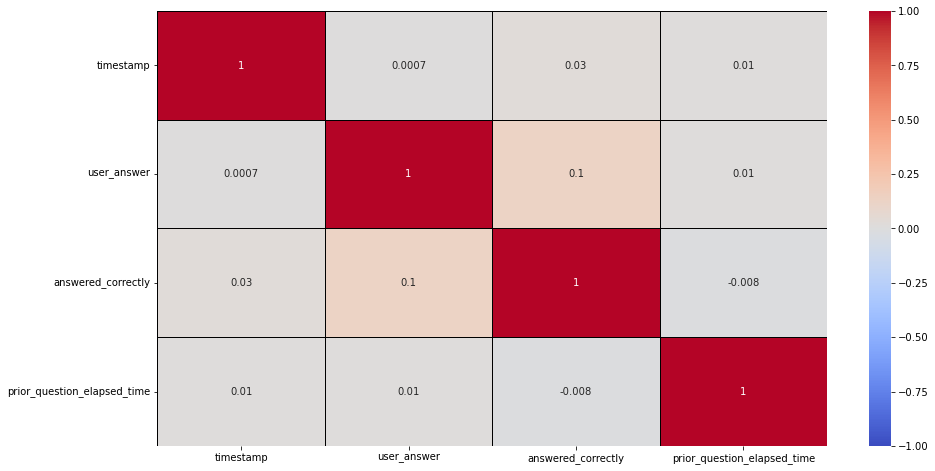

In [16]:
corr = df_train[numeric].corr(method="pearson")

fig, ax = plt.subplots(figsize = (15,8))

ax = sns.heatmap(corr, 
                 annot=True, 
                 fmt = '.1g',
                 vmin=-1, vmax=1, center= 0,
                 cmap='coolwarm',
                 linewidths=1, linecolor='black')

Корреляция минимальная

# Анализ признаков

In [21]:
df_train.head(2)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0.000000,115,5692,0,1,3,1,NaN,True
1,1,0.000949,115,5716,0,2,2,1,37.0,False


In [23]:
df_lectures.head(2)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept


In [24]:
df_questions.head(2)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


In [27]:
print(f'Студенты правильно отвечали на каждый {round(df_questions.correct_answer.mean(),1)} вопрос')

Студенты правильно отвечали на каждый 1.5 вопрос


In [33]:
print(f'Среднее время ответа = {round(df_train.prior_question_elapsed_time.mean())} секунд')

Среднее время ответа = 13 секунд


In [38]:
df_questions.groupby('part').agg(Правильных_ответов = ('correct_answer', sum)).sort_values(by='Правильных_ответов', ascending=False)

,Правильных_ответов
part,
5,8017
3,2342
2,2159
4,2126
7,1795
6,1751
1,1490


Больше всего правильных ответов на тему 5, тема 1 напротив была по-видимому самой сложной

In [43]:
correct_next_answer = df_train \
    .groupby('prior_question_had_explanation').agg(Правильных_ответов = ('answered_correctly', sum)) \
    .reset_index()
correct_next_answer

,prior_question_had_explanation,Правильных_ответов
0,False,2643367.0
1,True,60642228.0


In [60]:
ratio = correct_next_answer.iloc[1][1] / correct_next_answer.iloc[0][1]

In [62]:
print(f'Если предыдущий ответ объяснялся, правильных ответов на следующий было в {round(ratio)} раза больше, чем без объяснений')

Если предыдущий ответ объяснялся, правильных ответов на следующий было в 23 раза больше, чем без объяснений


In [63]:
df_train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

In [69]:
# по просмотрам лекций
correct_answer_for_lecture_wacthers = df_train \
    .groupby('content_type_id').agg(Правильных_ответов = ('answered_correctly', sum)) \
    .reset_index()
correct_answer_for_lecture_wacthers

,content_type_id,Правильных_ответов
0,0,65244627.0
1,1,-1959032.0


In [74]:
# по сборкам вопросов
correct_answer_for_bundles = df_questions \
    .groupby('bundle_id').agg(Правильных_ответов = ('correct_answer', sum)) \
    .reset_index() \
    .sort_values(by='Правильных_ответов', ascending=False)
correct_answer_for_bundles

,bundle_id,Правильных_ответов
5623,8079,13
5418,7734,13
5411,7699,13
5255,7153,13
5627,8099,12
...,...,...
3778,5210,0
7128,9652,0
7129,9653,0
1068,1068,0
